## 模擬訓練資料

In [1]:
import numpy as np
 # 模擬資料
texts = [
    "happy good", "sad bad", "excellent happy", "terrible sad",
    "wonderful great", "awful poor", "good wonderful", "bad awful",
    "amazing fantastic", "horrible dreadful", "pleasant delightful", "unpleasant miserable",
    "lovely amazing", "disgusting horrible", "fantastic wonderful", "dreadful awful"
]
y = np.array([[1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0]])

## 用BEP Tokenizer轉換文字

In [2]:
from tokenizer import BPE    # 1.2章節所建立的文件
from collections import Counter

# 將每個文字通過空白進行切割
tokens = [token for text in texts for token in text.split()]
vocab = Counter(tokens)

# 初始化BPE
tokenizer = BPE(vocab)
bpe_tokens = tokenizer.bpe_iterate(30)
x = [tokenizer(text) for text in texts]

# 測試結果
print(f'原始文字: {texts[0]} 轉換後的Token_ids: {tokenizer(texts[0])}')
print(f'訓練資料數: {len(x)}')

原始文字: happy good 轉換後的Token_ids: [28, 30]
訓練資料數: 16


## 手刻NLP模型

In [3]:
class SentimentModel:
    def __init__(self, vocab_size, embed_dim, output_dim):
        # 初始化詞嵌入層E
        self.embedding_matrix = np.random.randn(vocab_size, embed_dim) * 0.01 

        # 初始化線性分類器權重W和偏移量b
        self.W = np.random.randn(embed_dim, output_dim) * 0.01
        self.b = np.zeros(output_dim)

    def forward(self, word_indices, y):
        # 將Token轉換成嵌入層特徵 (公式2.1)
        word_embeddings = self.embedding_matrix[word_indices] 
        # 計算句子向量 (公式2.2)
        sentence_vector = np.mean(word_embeddings, axis=0)    
        # 線性分類器輸出 (公式2.3)
        z = np.dot(sentence_vector, self.W) + self.b          
        # 預測輸出 (公式2.4)
        y_hat  = self.sigmoid(z)                              
        
        # 回傳損失值與預測值
        return self.binary_cross_entropy_loss(y_hat, y), y_hat 

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z)) # 預測輸出 (公式2.5)

    def binary_cross_entropy_loss(self, y_hat, y):
        epsilon = 1e-15 # 加入一個微小數值防止log(0)
        y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
        
        return -np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)) # 返回損失值
    
    def backward(self, word_indices, y_hat, y, learning_rate):
        # 線性分類器對於損失值梯度 (公式2.11)
        dz = y_hat - y 
        # 計算平均向量 (公式1.1)
        sentence_vector = np.mean(self.embedding_matrix[word_indices], axis=0) 
        # 權重的梯度 (公式2.12)
        dW = np.outer(sentence_vector, dz)
        # 偏移量的梯度 (公式2.13)
        db = dz     

        # 句子向量的梯度 (公式2.15)
        ds = np.dot(dz, self.W.T)    
        # 每個token的詞嵌入梯度 (公式2.16)
        de = ds / len(word_indices)  

        # 用於儲存每個token的梯度
        dE = np.zeros_like(self.embedding_matrix)
        # 累積梯度 (公式2.17)
        np.add.at(dE, word_indices, de) 

        # 梯度下降法 (公式2.18)
        self.W -= learning_rate * dW
        self.b -= learning_rate * db
        self.embedding_matrix -= learning_rate * dE

    def predict(self, x):
        # 只需要計算機率值因此可以隨便傳入數字
        _, pred = self.forward(x, 0) 

        # 輸出類別與機率值
        return "正面" if pred > 0.5 else "負面", pred[0] 
    

    
# 通常Embedding層的大小會等同於Tokenizer中的Token量
vocab_size = len(tokenizer.tokens) 
# 設定每個Token有2個特徵值
embed_dim = 2 
# BCE Loss的輸出一定要是1
output_dim = 1
model = SentimentModel(vocab_size, embed_dim, output_dim)

## 訓練神經網路

In [4]:
def train(x, y, model, epochs=20, learning_rate=0.01):
    history = []
    for epoch in range(epochs):
        total_loss = 0
        for tokens_ids, label in zip(x, y):

            # 訓練模型
            loss, y_hat = model.forward(tokens_ids, label)          # 前向傳播
            model.backward(tokens_ids, y_hat, label, learning_rate) # 反向傳播
            
            total_loss += loss
        avg_loss = total_loss / len(texts) # 計算平均損失
        history.append(avg_loss)           # 紀錄平均損失
        
        # 顯示平均損失值
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss}")
    
    return history

history = train(x, y, model, epochs=1000, learning_rate=0.05)


Epoch 0, Loss: 0.699435508601718
Epoch 10, Loss: 0.6994447201553753
Epoch 20, Loss: 0.6994335597228285
Epoch 30, Loss: 0.6993906033108962
Epoch 40, Loss: 0.6992627252893613
Epoch 50, Loss: 0.6988858074265835
Epoch 60, Loss: 0.6977776314865547
Epoch 70, Loss: 0.6945434852925404
Epoch 80, Loss: 0.6853106654101195
Epoch 90, Loss: 0.6605523633371817
Epoch 100, Loss: 0.6041156512631444
Epoch 110, Loss: 0.5121967220792388
Epoch 120, Loss: 0.41674109759911104
Epoch 130, Loss: 0.34493039798348857
Epoch 140, Loss: 0.2952884580355595
Epoch 150, Loss: 0.2593825280875346
Epoch 160, Loss: 0.23153984648826686
Epoch 170, Loss: 0.20867256843792778
Epoch 180, Loss: 0.18911562934891882
Epoch 190, Loss: 0.17193968685431138
Epoch 200, Loss: 0.15660614861913835
Epoch 210, Loss: 0.1427917702320169
Epoch 220, Loss: 0.1302937400073546
Epoch 230, Loss: 0.11897513892746737
Epoch 240, Loss: 0.10873295182634768
Epoch 250, Loss: 0.09947999654411882
Epoch 260, Loss: 0.09113575069651005
Epoch 270, Loss: 0.0836226323

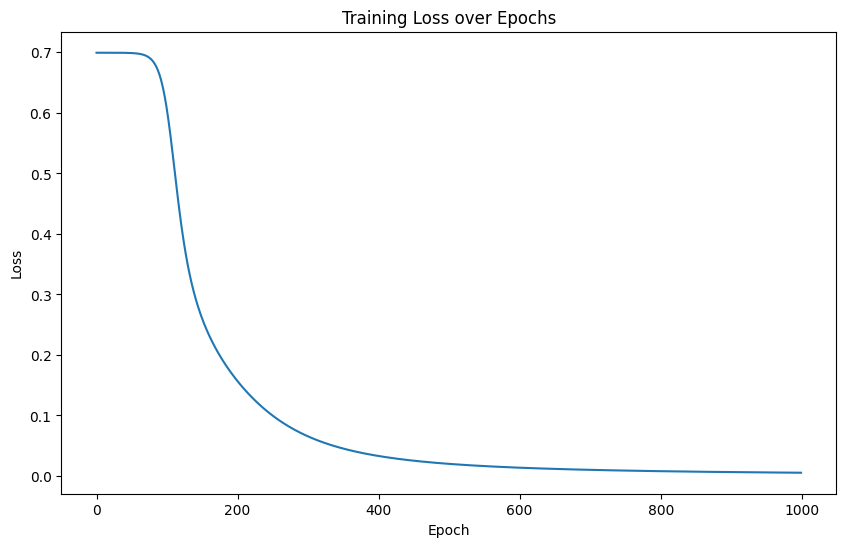

In [5]:
import matplotlib.pyplot as plt

def visualize_training(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

# 可視化訓練過程
visualize_training(history)


## 視覺化詞嵌入層

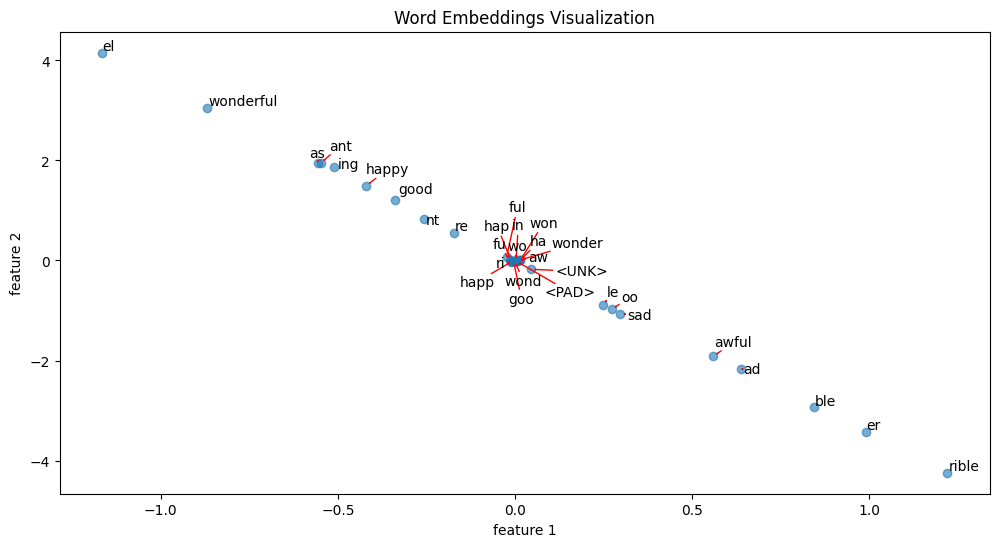

In [6]:
from adjustText import adjust_text

def visualize_embeddings(token_to_id, model):
    # 從鍵中取得token名稱
    words = list(token_to_id.keys())
    # 用對應的token索引取得embedding特徵資料
    embeddings = model.embedding_matrix[list(token_to_id.values())]     

    plt.figure(figsize=(12, 6))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.6) # 繪製散點圖

    texts = []
    for i, word in enumerate(words):
        # 為每個詞繪製文字標籤，並將標籤物件加入texts列表
        texts.append(plt.text(embeddings[i, 0], embeddings[i, 1], word))
    
    # 使用adjust_text自動調整文字標籤的位置，並為標籤添加箭頭
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
    
    # 設定圖表標題和軸標籤
    plt.title('Word Embeddings Visualization')
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    # 顯示圖表
    plt.show()

# 可視化詞嵌入
visualize_embeddings(tokenizer.token_to_id, model)


## 實際使用模型

In [7]:
tokens_ids = tokenizer('horrible')
sentiment, score = model.predict(tokens_ids)
print(sentiment, score)

負面 4.235981193321176e-06
